In [33]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, vstack
import astropy.units as u
from astropy.coordinates import SkyCoord
from reproject import reproject_interp, reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
import dja_sepp
from dja_sepp.utils import color_dict

In [52]:
home = "/FlashStorage/DJA-SEpp"
field = 'ceers-full-grizli-v7.2'
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
phot_tiles = []
tiles = glob.glob(f"{home}/fields/{field}/sepp/*sci_cutout*tile*sepp_cat.fits")
tiles.sort()
for tile in tiles:
    with fits.open(tile) as hdul:
        phot_tiles.append(Table(hdul[1].data))

OSError: Empty or corrupt FITS file

In [ ]:
print(f"{'Sources in DJA catalog':<28} : {len(phot_dja)}")
# print(phot_dja.keys())
for i, tile in enumerate(phot_tiles):
    print(f"{f'Sources in SE++ catalog ({i})':<28} : {len(tile)}")
    print(len(tile.keys()))

Sources in DJA catalog       : 76637
Sources in SE++ catalog (0)  : 2111
['pixel_centroid_x', 'pixel_centroid_y', 'world_centroid_alpha', 'world_centroid_delta', 'source_id', 'detection_id', 'group_id', 'group_stamp_top', 'group_stamp_left', 'group_stamp_width', 'group_stamp_height', 'source_flags', 'n_detected_pixels', 'n_core_pixel', 'APER_flux', 'APER_flux_err', 'APER_mag', 'APER_mag_err', 'APER_flags', 'auto_flux', 'auto_flux_err', 'auto_mag', 'auto_mag_err', 'auto_flags', 'flux_radius', 'snrratio', 'ellipse_a', 'ellipse_b', 'ellipse_theta', 'ellipse_cxx', 'ellipse_cyy', 'ellipse_cxy', 'area', 'elongation', 'ellipticity', 'fmf_reduced_chi_2', 'fmf_iterations', 'fmf_stop_reason', 'fmf_duration', 'fmf_flags', 'fmf_chi2_per_meta', 'fmf_iterations_per_meta', 'fmf_meta_iterations', 'X_MODEL', 'X_MODEL_err', 'Y_MODEL', 'Y_MODEL_err', 'RA_MODEL', 'RA_MODEL_err', 'DEC_MODEL', 'DEC_MODEL_err', 'RADIUS', 'RADIUS_err', 'AXRATIO', 'AXRATIO_err', 'ANGLE', 'ANGLE_err', 'E1', 'E1_err', 'E2', 'E2_

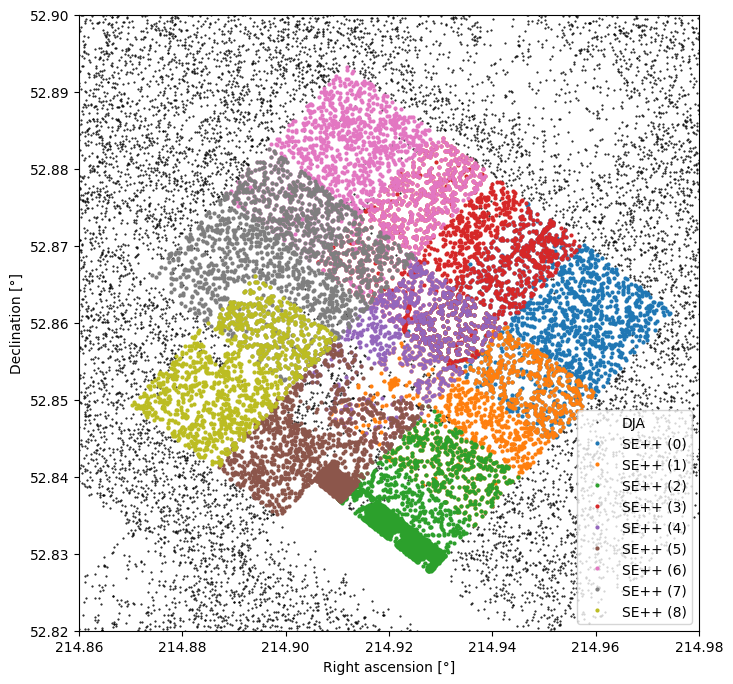

In [49]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
for i, tile in enumerate(phot_tiles):
    ax.plot(tile['world_centroid_alpha'], tile['world_centroid_delta'], marker='o', ls='', ms=2, label=f'SE++ ({i})')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
ax.set_xlim(214.86, 214.98)
ax.set_ylim(52.82, 52.90)
ax.legend()
plt.show()

In [32]:
def merge_catalogs(cat1, cat2, max_sep=0.25*u.arcsec, filter_merge='f200w', return_matches=False):
    coord1 = SkyCoord(cat1['world_centroid_alpha']*u.degree, cat1['world_centroid_delta']*u.degree)
    coord2 = SkyCoord(cat2['world_centroid_alpha']*u.degree, cat2['world_centroid_delta']*u.degree)
    idx, d2d, _ = coord1.match_to_catalog_sky(coord2)
    match1 = np.where(d2d<max_sep)[0]
    match2 = idx[match1]
    merge_choice = cat1[match1][f'MAG_MODEL_{filter_merge.upper()}_err']<cat2[match2][f'MAG_MODEL_{filter_merge.upper()}_err']
    merged_1 = cat1[match1][merge_choice]
    merged_2 = cat2[match2][~merge_choice]
    cat1_unmatched = cat1[[i for i in range(len(cat1)) if i not in match1]]
    cat2_unmatched = cat2[[i for i in range(len(cat2)) if i not in match2]]
    merged = vstack([cat1_unmatched, cat2_unmatched, merged_1, merged_2])
    if return_matches: return merged, match1, match2
    return merged

def merge_tiles(catalogs, max_sep=0.25*u.arcsec, filter_merge='f200w'):
    merged = catalogs[0]
    for i in range(1, len(catalogs)):
        merged = merge_catalogs(catalogs[i], merged, max_sep, filter_merge)
    return merged

def merge_images(folder, filter_list, type, exact=False, out_folder=None):
    for filter in filter_list:
        images = glob.glob(f"{folder}/*{type}*{filter}*")
        wcs_out, shape_out = find_optimal_celestial_wcs(images, auto_rotate=True)
        reproject_function = reproject_exact if exact else reproject_interp
        mosaic, footprint = reproject_and_coadd(images, wcs_out, shape_out=shape_out, 
                                                reproject_function=reproject_function,
                                                match_background=False)
        out_folder = '/'.join(images[0].split('/')[:-1]) if out_folder is None else out_folder
        ### SAVE IMAGE WITH WCS

In [22]:
phot_full = merge_tiles(phot_tiles)

TableMergeError: columns have different shapes

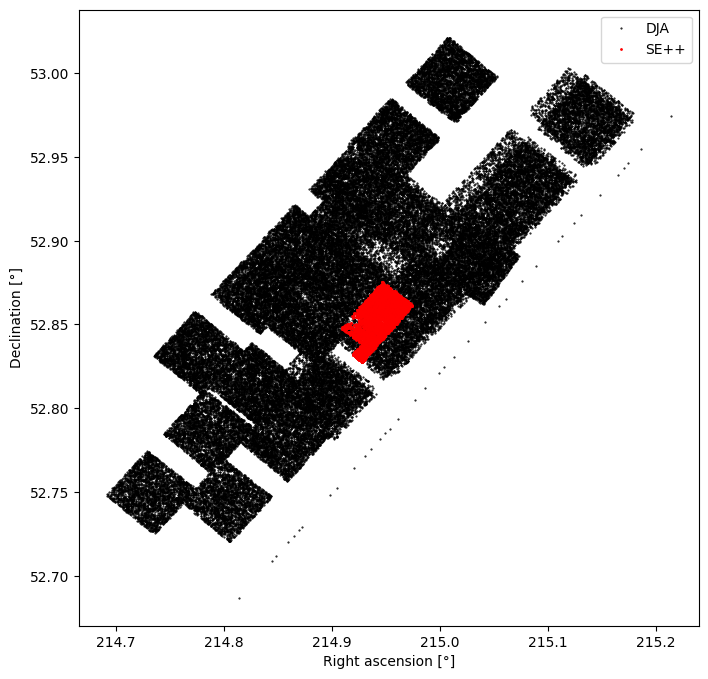

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_full['world_centroid_alpha'], phot_full['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label=f'SE++')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.86, 214.98)
# ax.set_ylim(52.83, 52.90)
ax.legend()
plt.show()